### STEP1 - IMPORTS

In [1]:
# Imports & data
import math, itertools
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix

# Repro & device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


### STEP 2 - DATA

In [2]:
# Transforms (standard MNIST normalization)
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Datasets (download if needed)
train_full = datasets.MNIST(root="./data", train=True,  download=True, transform=tfm)
test_set   = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)

# Train/val split (50k/10k)
train_set, val_set = random_split(
    train_full, [50000, len(train_full)-50000],
    generator=torch.Generator().manual_seed(42)
)

# DataLoaders
BATCH_SIZE = 128
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train/Val/Test: {len(train_set)}/{len(val_set)}/{len(test_set)}")

Train/Val/Test: 50000/10000/10000


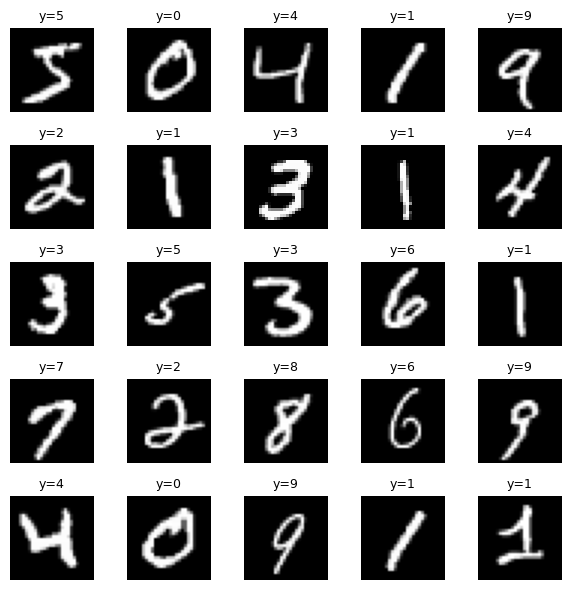

In [3]:
MEAN, STD = 0.1307, 0.3081

fig, axes = plt.subplots(5, 5, figsize=(6,6))
axes = axes.flatten()
for i in range(25):
    img, label = train_full[i]            # (1,28,28) normalized tensor, int label
    img = (img * STD + MEAN).squeeze(0)   # de-normalize & drop channel
    axes[i].imshow(img.numpy(), cmap="gray")
    axes[i].set_title(f"y={label}", fontsize=9)
    axes[i].axis("off")
plt.tight_layout()
plt.show()


### STEP 3 - CNN MODEL

In [4]:
# CNN model
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes: int = 10,
                 kernel_size=3, num_convs=2, agg='gap'):
        super().__init__()
        assert agg in ('flatten', 'gap')
        self.agg = agg

        channels = [32, 64, 128][:max(1, min(num_convs, 3))]
        blocks, c_prev, pad = [], in_channels, kernel_size // 2
        for c in channels:
            blocks += [
                nn.Conv2d(c_prev, c, kernel_size=kernel_size, padding=pad, bias=False),
                nn.BatchNorm2d(c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
            ]
            c_prev = c
        self.features = nn.Sequential(*blocks)

        if agg == 'gap':
            self.head = nn.Linear(c_prev, num_classes)
        else:
            with torch.no_grad():
                dummy = torch.zeros(1, 1, 28, 28)
                f = self.features(dummy)
                flat_dim = f.numel()
            self.head = nn.Linear(flat_dim, num_classes)

    def forward(self, x):
        x = self.features(x)
        if self.agg == 'gap':
            x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        else:
            x = torch.flatten(x, 1)
        return self.head(x)
# Training helpers tracking train/val loss & accuracy per epoch
@torch.no_grad()
def evaluate_metrics(model, loader, device, criterion):
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss    += loss.item() * yb.size(0)
        total_correct += (logits.argmax(1) == yb).sum().item()
        total         += yb.size(0)
    return total_loss/total, total_correct/total

def train_one_epoch(model, loader, optimizer, device, criterion):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss    += loss.item() * yb.size(0)
        running_correct += (logits.argmax(1) == yb).sum().item()
        total           += yb.size(0)
    return running_loss/total, running_correct/total

def fit(model, train_loader, val_loader, device, lr=1e-3, epochs=5):
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_val_acc, best_state = 0.0, None
    history = {"tr_loss": [], "tr_acc": [], "val_loss": [], "val_acc": []}

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, device, criterion)
        val_loss, val_acc = evaluate_metrics(model, val_loader, device, criterion)
        history["tr_loss"].append(tr_loss)
        history["tr_acc"].append(tr_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        print(f"Epoch {ep:02d} | "
              f"train loss {tr_loss:.4f} acc {tr_acc:.4f} | "
              f"val loss {val_loss:.4f} acc {val_acc:.4f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_val_acc, history

@torch.no_grad()
def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb).argmax(1)
        correct += (pred == yb).sum().item()
        total   += yb.size(0)
    return correct / total



### STEP 4 - CURVES

  0%|          | 0/391 [00:15<?, ?it/s]

Epoch 01 | train loss 1.4037 acc 0.6608 | val loss 0.9410 acc 0.7814


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 02 | train loss 0.6809 acc 0.8668 | val loss 0.5681 acc 0.8531


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 03 | train loss 0.4343 acc 0.9093 | val loss 0.3804 acc 0.9117


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 04 | train loss 0.3261 acc 0.9280 | val loss 0.3089 acc 0.9252


  0%|          | 0/391 [00:17<?, ?it/s]

Epoch 01 | train loss 0.6795 acc 0.8021 | val loss 0.2857 acc 0.9177


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 02 | train loss 0.1905 acc 0.9500 | val loss 0.2783 acc 0.9181


  0%|          | 0/391 [00:17<?, ?it/s]

Epoch 03 | train loss 0.1364 acc 0.9612 | val loss 0.1734 acc 0.9468


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 04 | train loss 0.1122 acc 0.9683 | val loss 0.2227 acc 0.9304


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 01 | train loss 0.3091 acc 0.9390 | val loss 0.1382 acc 0.9648


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 02 | train loss 0.0596 acc 0.9854 | val loss 0.0813 acc 0.9755


  0%|          | 0/391 [00:15<?, ?it/s]

Epoch 03 | train loss 0.0396 acc 0.9898 | val loss 0.0969 acc 0.9687


  0%|          | 0/391 [00:17<?, ?it/s]

Epoch 04 | train loss 0.0300 acc 0.9924 | val loss 0.0484 acc 0.9848


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 01 | train loss 0.1932 acc 0.9450 | val loss 0.1455 acc 0.9552


  0%|          | 0/391 [00:17<?, ?it/s]

Epoch 02 | train loss 0.0442 acc 0.9861 | val loss 0.0806 acc 0.9737


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 03 | train loss 0.0329 acc 0.9898 | val loss 0.0302 acc 0.9914


  0%|          | 0/391 [00:18<?, ?it/s]

Epoch 04 | train loss 0.0247 acc 0.9916 | val loss 0.0445 acc 0.9869


  0%|          | 0/391 [00:18<?, ?it/s]

Epoch 01 | train loss 0.9169 acc 0.8231 | val loss 0.4522 acc 0.8958


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 02 | train loss 0.2500 acc 0.9521 | val loss 0.2167 acc 0.9479


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 03 | train loss 0.1576 acc 0.9657 | val loss 0.1614 acc 0.9610


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 04 | train loss 0.1201 acc 0.9722 | val loss 0.1302 acc 0.9627


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 01 | train loss 0.3700 acc 0.8975 | val loss 0.1492 acc 0.9573


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 02 | train loss 0.0845 acc 0.9763 | val loss 0.0798 acc 0.9763


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 03 | train loss 0.0619 acc 0.9818 | val loss 0.1307 acc 0.9566


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 04 | train loss 0.0486 acc 0.9854 | val loss 0.0671 acc 0.9792


  0%|          | 0/391 [00:17<?, ?it/s]

Epoch 01 | train loss 0.1661 acc 0.9639 | val loss 0.1650 acc 0.9432


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 02 | train loss 0.0382 acc 0.9893 | val loss 0.0768 acc 0.9777


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 03 | train loss 0.0257 acc 0.9927 | val loss 0.0615 acc 0.9816


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 04 | train loss 0.0191 acc 0.9949 | val loss 0.0440 acc 0.9849


  0%|          | 0/391 [00:17<?, ?it/s]

Epoch 01 | train loss 0.1577 acc 0.9527 | val loss 0.1061 acc 0.9679


  0%|          | 0/391 [00:17<?, ?it/s]

Epoch 02 | train loss 0.0391 acc 0.9876 | val loss 0.0428 acc 0.9866


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 03 | train loss 0.0288 acc 0.9916 | val loss 0.0454 acc 0.9872


  0%|          | 0/391 [00:17<?, ?it/s]

Epoch 04 | train loss 0.0228 acc 0.9925 | val loss 0.0433 acc 0.9855


  0%|          | 0/391 [00:15<?, ?it/s]

Epoch 01 | train loss 0.6001 acc 0.8932 | val loss 0.2782 acc 0.9287


  0%|          | 0/391 [00:15<?, ?it/s]

Epoch 02 | train loss 0.1526 acc 0.9668 | val loss 0.1418 acc 0.9648


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 03 | train loss 0.1009 acc 0.9763 | val loss 0.1429 acc 0.9585


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 04 | train loss 0.0771 acc 0.9815 | val loss 0.1144 acc 0.9692


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 01 | train loss 0.3043 acc 0.9148 | val loss 0.1092 acc 0.9665


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 02 | train loss 0.0668 acc 0.9804 | val loss 0.0951 acc 0.9704


  0%|          | 0/391 [00:17<?, ?it/s]

Epoch 03 | train loss 0.0468 acc 0.9855 | val loss 0.0636 acc 0.9800


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 04 | train loss 0.0388 acc 0.9882 | val loss 0.0666 acc 0.9793


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 01 | train loss 0.1437 acc 0.9666 | val loss 0.0598 acc 0.9830


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 02 | train loss 0.0362 acc 0.9895 | val loss 0.0529 acc 0.9826


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 03 | train loss 0.0224 acc 0.9935 | val loss 0.0413 acc 0.9861


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 04 | train loss 0.0180 acc 0.9949 | val loss 0.0441 acc 0.9874


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 01 | train loss 0.1580 acc 0.9526 | val loss 0.0526 acc 0.9833


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 02 | train loss 0.0417 acc 0.9872 | val loss 0.0630 acc 0.9817


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 03 | train loss 0.0304 acc 0.9905 | val loss 0.0375 acc 0.9888


  0%|          | 0/391 [00:16<?, ?it/s]

Epoch 04 | train loss 0.0244 acc 0.9920 | val loss 0.0390 acc 0.9884


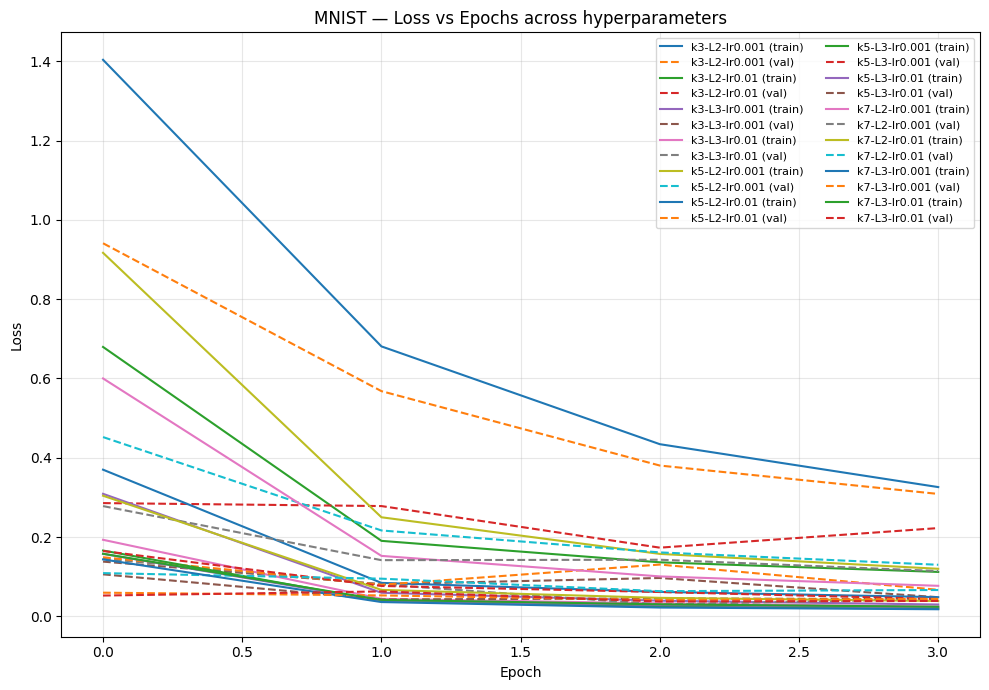

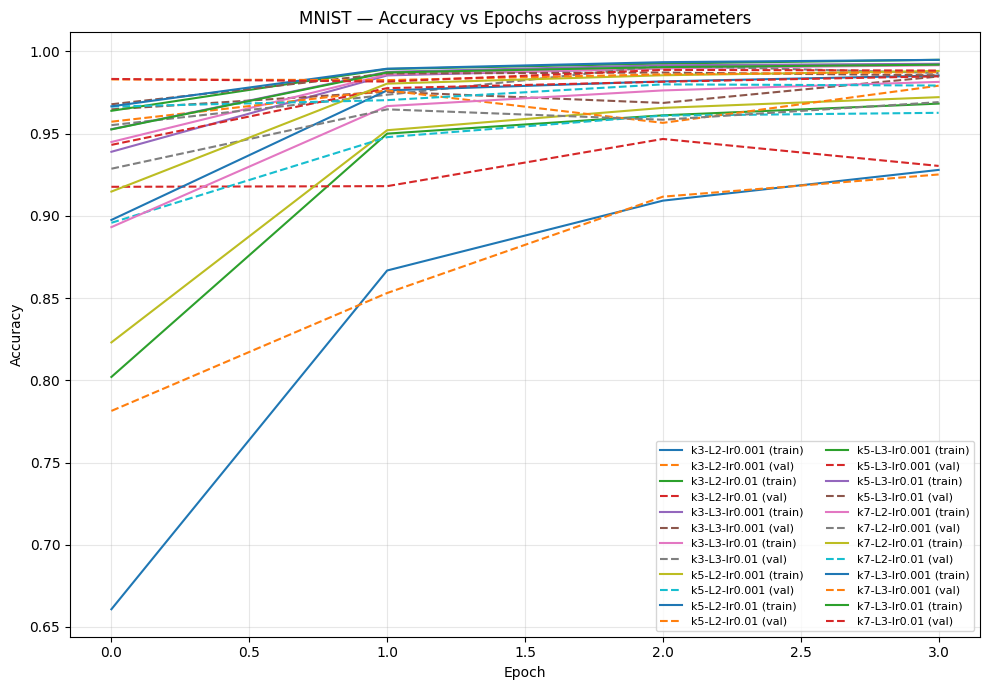

In [ ]:
# Hyperparameter sweep and plots of loss/accuracy vs epochs (train & val)
kernels = [3, 5, 7]
layers  = [2, 3]
lrs     = [1e-3, 1e-2]
epochs  = 4  

runs = []  # list of {"label", "hist", "best_val", "state"}

for k in kernels:
    for n in layers:
        for lr in lrs:
            label = f"k{k}-L{n}-lr{lr:g}"
            model = CNN(kernel_size=k, num_convs=n, agg='gap')
            model, best_val, hist = fit(model, train_loader, val_loader, device, lr=lr, epochs=epochs)
            runs.append({"label": label, "hist": hist, "best_val": best_val})

# --- Plot: Loss curves (train solid, val dashed)
plt.figure(figsize=(10,7))
for r in runs:
    h = r["hist"]
    plt.plot(h["tr_loss"], label=f"{r['label']} (train)")
    plt.plot(h["val_loss"], linestyle="--", label=f"{r['label']} (val)")
plt.title("MNIST — Loss vs Epochs across hyperparameters")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout(); plt.show()

# --- Plot: Accuracy curves (train solid, val dashed)
plt.figure(figsize=(10,7))
for r in runs:
    h = r["hist"]
    plt.plot(h["tr_acc"], label=f"{r['label']} (train)")
    plt.plot(h["val_acc"], linestyle="--", label=f"{r['label']} (val)")
plt.title("MNIST — Accuracy vs Epochs across hyperparameters")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=8)
plt.tight_layout(); plt.show()


### CONFUSION MATRIX

Best combo: k3-L3-lr0.01 val_acc= 0.9914


  0%|          | 0/391 [00:15<?, ?it/s]

Epoch 01 | train loss 0.2067 acc 0.9415 | val loss 0.0863 acc 0.9723


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 02 | train loss 0.0457 acc 0.9863 | val loss 0.0392 acc 0.9877


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 03 | train loss 0.0309 acc 0.9906 | val loss 0.0517 acc 0.9850


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 04 | train loss 0.0254 acc 0.9918 | val loss 0.0640 acc 0.9818


  0%|          | 0/391 [00:14<?, ?it/s]

Epoch 05 | train loss 0.0229 acc 0.9930 | val loss 0.0595 acc 0.9826
Test accuracy: 0.9874


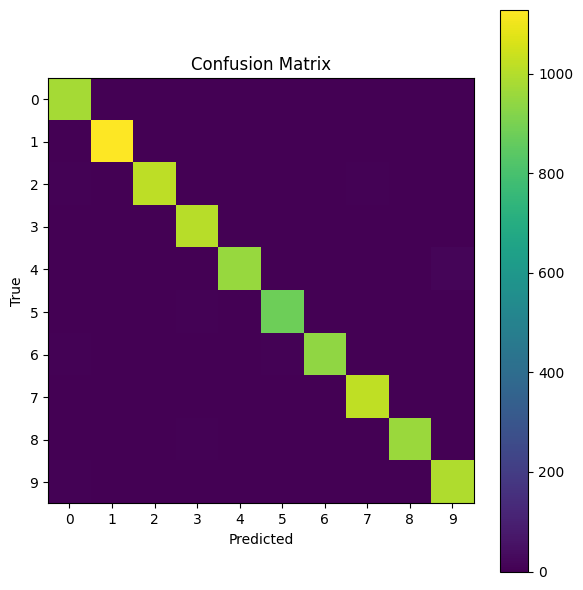

In [6]:
# Find best by validation accuracy and evaluate on test; plot confusion matrix
best_run = max(runs, key=lambda r: r["best_val"])
print("Best combo:", best_run["label"], "val_acc=", f"{best_run['best_val']:.4f}")

# Re-train best config a bit longer (optional)
k = int(best_run["label"].split('-')[0][1:])
n = int(best_run["label"].split('-')[1][1:])
lr = float(best_run["label"].split('-')[2][2:])
best_model = CNN(kernel_size=k, num_convs=n, agg='gap')
best_model, _, _ = fit(best_model, train_loader, val_loader, device, lr=lr, epochs=5)

# Test accuracy + confusion matrix
test_acc = evaluate_accuracy(best_model, test_loader, device)
print("Test accuracy:", test_acc)

all_preds, all_labels = [], []
best_model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        pb = best_model(xb.to(device)).argmax(1).cpu()
        all_preds.append(pb); all_labels.append(yb)
all_preds  = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.colorbar(); plt.xticks(np.arange(10)); plt.yticks(np.arange(10))
plt.tight_layout(); plt.show()
